# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [1]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [2]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [3]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [4]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 5.611193 (||params||=3.891615, ||grad||=6.906607, ||E[dr/dw]||=4.839578)
INFO:root:Occupancy measure error@iter  100: 0.011910 (||params||=5.092519, ||grad||=0.016636, ||E[dr/dw]||=7.043176)
INFO:root:Occupancy measure error@iter  200: 0.007231 (||params||=5.176939, ||grad||=0.009971, ||E[dr/dw]||=7.047548)
INFO:root:Occupancy measure error@iter  300: 0.004938 (||params||=5.227907, ||grad||=0.006503, ||E[dr/dw]||=7.049842)
INFO:root:Occupancy measure error@iter  400: 0.003569 (||params||=5.260096, ||grad||=0.004485, ||E[dr/dw]||=7.051191)
INFO:root:Occupancy measure error@iter  500: 0.002689 (||params||=5.280765, ||grad||=0.003242, ||E[dr/dw]||=7.052035)
INFO:root:Occupancy measure error@iter  600: 0.002097 (||params||=5.294027, ||grad||=0.002454, ||E[dr/dw]||=7.052583)
INFO:root:Occupancy measure error@iter  700: 0.001683 (||params||=5.302394, ||grad||=0.001947, ||E[dr/dw]||=7.052945)
INFO:root:Occupancy measure error@iter  800: 0.001387 (||

In [5]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.9802e+00 6.2606e-03 0.0000e+00]
 [0.0000e+00 1.0130e+00 5.5136e-04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]

Recovered state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.9802e+00 5.6956e-03 0.0000e+00]
 [0.0000e+00 1.0140e+00 8.2769e-05 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [6]:
# ALRIGHT, HERE IS WHERE I WILL DEBUG THE TOPK FEEDBACK LEARNER
# ABLATIONS: COULD WE DO BETTER IF ALL OUR TRAJECTORIES ARE GOOD? 
# OR IS IT NECESSARY TO HAVE BAD TRAJECTORIES? 

In [7]:
import pref_bootstrap.feedback_learner_topk as fbl_topk

rmodel = r_models.LinearRewardModel(env.obs_dim)
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)

In [8]:
# def genereate_top_K_dataset(n_traj): 
import random

n_traj = 1000
traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
labels= top_K_expert.interact(traj)

labels_final, traj_final = [], []
for l, t in zip(labels, traj['states']): 
    if not(l):
        if True:#random.random() < (np.sum(labels)/len(labels)):
            labels_final.append(l), traj_final.append(t)
    else: 
        labels_final.append(l), traj_final.append(t)
        
labels_final = np.array(labels_final)
        
print(np.sum(labels)/len(labels))
print(np.sum(labels_final)/len(labels_final))


cutoff 30.0
0.074
0.074


In [9]:
def generate_topk_dataset(n_traj):
    # def genereate_top_K_dataset(n_traj): 
    import random
    traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
    labels= top_K_expert.interact(traj)

    labels_final, traj_final = [], []
    for l, t in zip(labels, traj['states']): 
        if not(l):
            if random.random() < top_K_expert.K:#TODO if there are issues update this so that we balance our dataset.
                labels_final.append(l), traj_final.append(t)
        else: 
            labels_final.append(l), traj_final.append(t)

    labels_final = np.array([int(l) for l in labels_final])
    
    return {
        'trajectories':np.array(traj_final), 
        'labels':labels_final
    }

top_K_dataset = generate_topk_dataset(1000)


cutoff 30.0


In [16]:
lr = 1e-3
steps = 10000
loss_prev = float('Inf')
delta = 100
eps = 1e-5

import pref_bootstrap.feedback_learner_topk as fbl_topk
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)
rmodel = r_models.LinearRewardModel(env.obs_dim)
import jax
import jax.numpy as jnp

rng = jrandom.PRNGKey(42)
rng, top_K_bias_params = top_K_feedback_model.init_bias_params(rng)

In [30]:



def trad_optimize(model, data, rmodel, bias_params, eps=1e-9):
    
    lr = 1e-2
    steps = 1000
    loss_prev = float('Inf')
    delta = 100
 
    step = 0
    
    while(np.abs(delta) > eps and step<steps):
        gbias = model.log_likelihood_grad_bias(data, rmodel, bias_params)
        
        grew = model.log_likelihood_grad_rew(data, rmodel, bias_params)
        new_r = rmodel.get_params() + lr*grew
        rmodel.set_params(new_r)
        loss = model.log_likelihood(data, rmodel, bias_params)
        if step % 100 == 0:
            print('step %d loss %.3f' %(step, loss))
        if step > 0: 
            delta = loss-loss_prev
        loss_prev = loss
        step +=1


       
     

        

    if np.abs(delta) <= .0001: 
        print('terminated due to delta')
    else: 
        print('terminated due to steps exceeding %d' %steps)
        
    return model, rmodel, bias_params

_, rmodel, _ = trad_optimize(top_K_feedback_model, top_K_dataset, rmodel, top_K_bias_params)

step 0 loss -3.805
step 100 loss -1.401
step 200 loss -0.575
step 300 loss -0.469
step 400 loss -0.427
step 500 loss -0.403
step 600 loss -0.387
step 700 loss -0.376
step 800 loss -0.368
step 900 loss -0.362
terminated due to delta


Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.9802e+00 6.2606e-03 0.0000e+00]
 [0.0000e+00 1.0130e+00 5.5136e-04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     5.3877 0.8337 0.    ]
 [0.     1.4381 0.3405 0.    ]
 [0.     0.     0.     0.    ]]


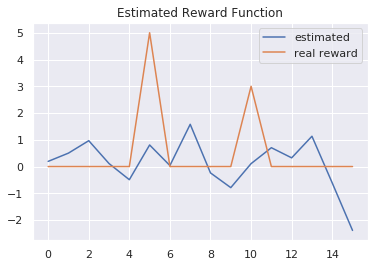

In [25]:
def evaluate(rmodel):
    plt.plot(rmodel.get_params(), label='estimated')
    plt.plot(env.reward_matrix, label='real reward')
    plt.legend()
    plt.title('Estimated Reward Function')

    _, topk_om = mce_irl.mce_occupancy_measures(env, R=rmodel.get_params())

    print('Optimal state visitation frequencies for each grid cell:')
    print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))

    print('Inferred ')
    print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))
    
evaluate(rmodel)

In [26]:
# Now can we get another feedback modality to work with the traditional grad descent? 

In [31]:
pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
rng, pc_bias_params = pc_feedback_model.init_bias_params(rng)
pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

# generate some random trajectories & compare a random subset of them
def generate_comparison_dataset(pc_ntraj):
    pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
    to_compare_first = np.arange(len(pc_trajectories['states']))
    comparisons = []
    for first_idx in range(pc_ntraj):
        second_idx = np.random.randint(pc_ntraj - 1)
        if second_idx >= first_idx:
            second_idx += 1
        traj1_is_better = pc_expert.interact(
            dict(states=pc_trajectories['states'][first_idx]),
            dict(states=pc_trajectories['states'][second_idx]))
        if traj1_is_better:
            # the better trajectory comes before the worse one
            comparisons.append((first_idx, second_idx))
        else:
            comparisons.append((second_idx, first_idx))
    return {
        'trajectories': pc_trajectories,
        'comparisons': np.asarray(comparisons),
    }

comparison_dataset = generate_comparison_dataset(10)

step 0 loss -0.321
step 100 loss -0.057
step 200 loss -0.046
step 300 loss -0.041
step 400 loss -0.037
step 500 loss -0.035
step 600 loss -0.032
step 700 loss -0.030
step 800 loss -0.029
step 900 loss -0.027
terminated due to delta
Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.9802e+00 6.2606e-03 0.0000e+00]
 [0.0000e+00 1.0130e+00 5.5136e-04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     6.3804 0.3736 0.    ]
 [0.     1.0954 0.1505 0.    ]
 [0.     0.     0.     0.    ]]


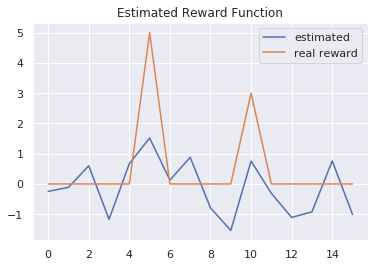

In [33]:
rmodel = r_models.LinearRewardModel(env.obs_dim)
_, rmodel, _ = trad_optimize(pc_feedback_model, comparison_dataset, rmodel, pc_bias_params)
evaluate(rmodel)

step 0 loss -12.275
step 100 loss -9.270
step 200 loss -8.877
step 300 loss -8.713
step 400 loss -8.619
step 500 loss -8.556
step 600 loss -8.511
step 700 loss -8.477
step 800 loss -8.450
step 900 loss -8.428
terminated due to steps exceeding 1000
Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.9802e+00 6.2606e-03 0.0000e+00]
 [0.0000e+00 1.0130e+00 5.5136e-04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Inferred 
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.9893e+00 7.5108e-03 0.0000e+00]
 [0.0000e+00 1.0031e+00 4.1789e-05 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


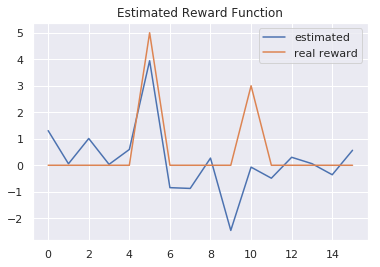

In [35]:
irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
rng = jrandom.PRNGKey(42)
rng, irl_bias_params = irl_feedback_model.init_bias_params(rng)
irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
# we'll do IRL based on 10 trajectories
irl_dataset = irl_expert.interact(10)
_, rmodel, _ = trad_optimize(irl_feedback_model, irl_dataset, rmodel, irl_bias_params)
evaluate(rmodel)